In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler 
import numpy as np
from sklearn.model_selection import train_test_split
import os, cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D

In [3]:
import pandas as pd
data = pd.read_csv('/kaggle/input/skin-cancer-mnist-ham10000/hmnist_28_28_RGB.csv')

In [4]:
y = data['label']
x = data.drop(columns = ['label'])

In [5]:
oversample = RandomOverSampler()
x,y  = oversample.fit_resample(x,y)

In [6]:
x = np.array(x).reshape(-1,28,28,3)
print('Shape of X :',x.shape)

Shape of X : (46935, 28, 28, 3)


In [7]:
tabular_data = pd.read_csv('/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv')
tabular_data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [8]:
classes = {4: ('nv', ' melanocytic nevi'), 6: ('mel', 'melanoma'), 2 :('bkl', 'benign keratosis-like lesions'), 1:('bcc' , ' basal cell carcinoma'), 5: ('vasc', ' pyogenic granulomas and hemorrhage'), 0: ('akiec', 'Actinic keratoses and intraepithelial carcinomae'),  3: ('df', 'dermatofibroma')}

In [13]:
t = np.zeros([46935, 32, 32, 3],dtype=np.float32)
print(t.shape)

(46935, 32, 32, 3)


In [14]:
import scipy.ndimage

In [15]:
for i in range(46935):
    t[i] = scipy.ndimage.zoom(x[i],32/28)

In [16]:
x = np.array(t).reshape(-1,32,32,3)
print('Shape of X :',x.shape)

Shape of X : (46935, 32, 32, 3)


In [17]:
"""Standardization and Splitting Data"""

x = (x-np.mean(x))/np.std(x)
X_train, X_test, Y_train, Y_test = train_test_split(x,y, test_size=0.2, random_state=1)

In [18]:
vgg=tf.keras.applications.VGG16(input_shape=(32,32,3),weights='imagenet', include_top=False)
for i in vgg.layers:
    i.trainable = False

58889256/58889256 [==============================] - 0s 0us/step


In [48]:
model = tf.keras.models.Sequential([
    vgg,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(7, activation = 'softmax')
])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 7)                 3591      
                                                                 
Total params: 14,718,279
Trainable params: 3,591
Non-trainable params: 14,714,688
_________________________________________________________________
None


In [50]:
callback = tf.keras.callbacks.ModelCheckpoint(filepath='best_model.h5',
                                                  monitor='val_acc', mode='max',
                                                 verbose=1)


In [51]:
model.compile(loss = 'sparse_categorical_crossentropy',
             optimizer = 'adam',
              metrics = ['accuracy'])
history = model.fit(X_train,
                    Y_train,
                    validation_split=0.2,
                    batch_size = 128,
                    epochs = 100,
                    callbacks=[callback])

Epoch 1/100
235/235 [==============================] - ETA: 0s - loss: 1.4183 - accuracy: 0.4748
Epoch 1: saving model to best_model.h5
235/235 [==============================] - 5s 19ms/step - loss: 1.4183 - accuracy: 0.4748 - val_loss: 1.1876 - val_accuracy: 0.5706
Epoch 2/100
231/235 [============================>.] - ETA: 0s - loss: 1.1196 - accuracy: 0.5908
Epoch 2: saving model to best_model.h5
235/235 [==============================] - 3s 15ms/step - loss: 1.1192 - accuracy: 0.5911 - val_loss: 1.0696 - val_accuracy: 0.6085
Epoch 3/100
235/235 [==============================] - ETA: 0s - loss: 1.0256 - accuracy: 0.6263
Epoch 3: saving model to best_model.h5
235/235 [==============================] - 4s 15ms/step - loss: 1.0256 - accuracy: 0.6263 - val_loss: 1.0001 - val_accuracy: 0.6372
Epoch 4/100
235/235 [==============================] - ETA: 0s - loss: 0.9678 - accuracy: 0.6447
Epoch 4: saving model to best_model.h5
235/235 [==============================] - 4s 15ms/step - lo

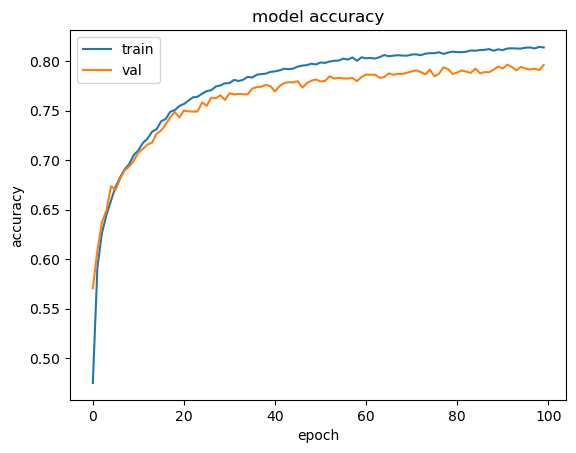

In [52]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Loss (training vs validation dataset)

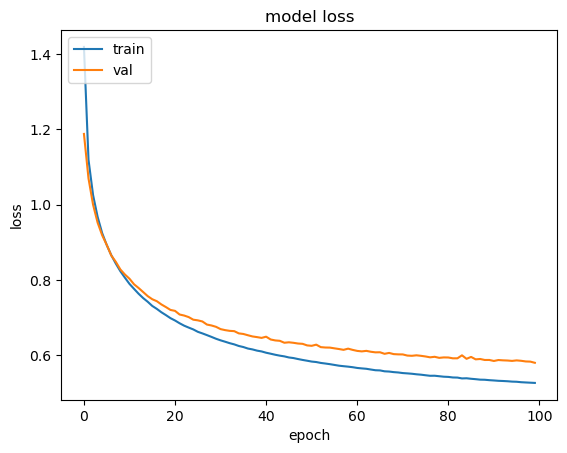

In [53]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [54]:
model.load_weights('best_model.h5')


In [55]:
loss, acc = model.evaluate(X_train, Y_train, verbose=2)

1174/1174 - 8s - loss: 0.5337 - accuracy: 0.8121 - 8s/epoch - 7ms/step


In [56]:
loss, acc = model.evaluate(X_test, Y_test, verbose=2)

294/294 - 2s - loss: 0.5786 - accuracy: 0.7979 - 2s/epoch - 7ms/step


In [57]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics

In [58]:
import sklearn.metrics as metrics

y_pred_ohe = model.predict(X_test) 
y_pred_labels = np.argmax(y_pred_ohe, axis=1) 

confusion_matrix = metrics.confusion_matrix(y_true=Y_test, y_pred=y_pred_labels)

294/294 [==============================] - 2s 6ms/step


In [59]:
class_labels = ['akiec','bcc','bkl','df','nv','vasc','mel']
report = sklearn.metrics.classification_report(Y_test, y_pred_labels, target_names = class_labels)
print(report) 

              precision    recall  f1-score   support

       akiec       0.77      0.82      0.80      1359
         bcc       0.77      0.81      0.79      1318
         bkl       0.65      0.60      0.63      1262
          df       0.91      0.99      0.95      1351
          nv       0.75      0.71      0.73      1374
        vasc       0.99      1.00      0.99      1358
         mel       0.71      0.64      0.67      1365

    accuracy                           0.80      9387
   macro avg       0.79      0.80      0.79      9387
weighted avg       0.79      0.80      0.79      9387



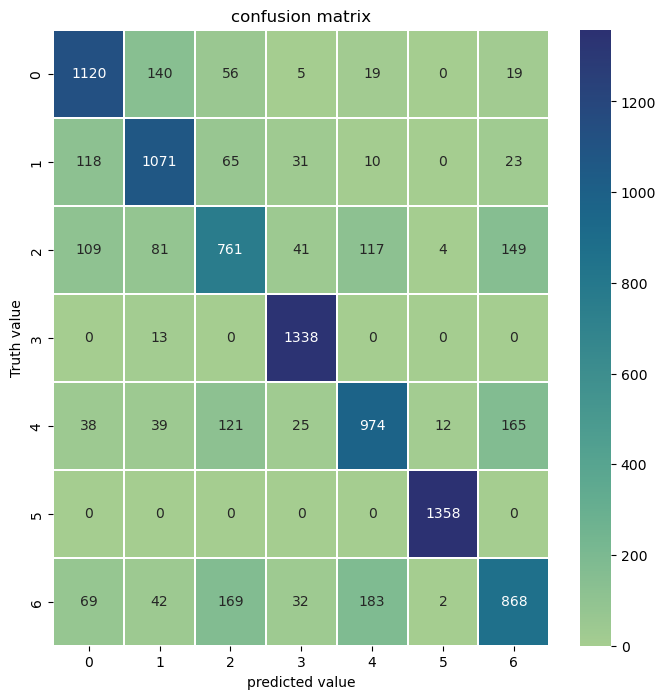

[[1120  140   56    5   19    0   19]
 [ 118 1071   65   31   10    0   23]
 [ 109   81  761   41  117    4  149]
 [   0   13    0 1338    0    0    0]
 [  38   39  121   25  974   12  165]
 [   0    0    0    0    0 1358    0]
 [  69   42  169   32  183    2  868]]


In [60]:
cm = sklearn.metrics.confusion_matrix(Y_test, y_pred_labels)
plt.figure(figsize=(8,8))
sns.heatmap(cm, fmt='.0f', cmap="crest", annot=True, linewidths=0.2 )
plt.title('confusion matrix')
plt.xlabel('predicted value')
plt.ylabel('Truth value')
plt.show()
print(sklearn.metrics.confusion_matrix(Y_test, y_pred_labels))

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


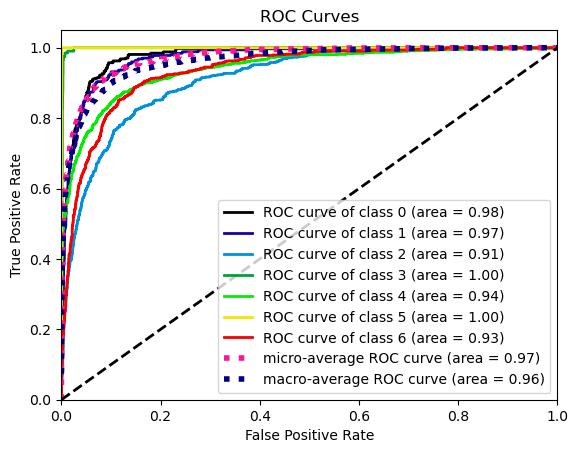

In [61]:
import scikitplot as skplt

skplt.metrics.plot_roc_curve(Y_test, y_pred_ohe)
plt.show()